In [1]:
# Hyperparameters

seq_length = 128
learning_rate = 0.001
num_epochs = 100
forecast_steps = 100

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

y = load_airline()
y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)

np.float64(0.08174636513175991)

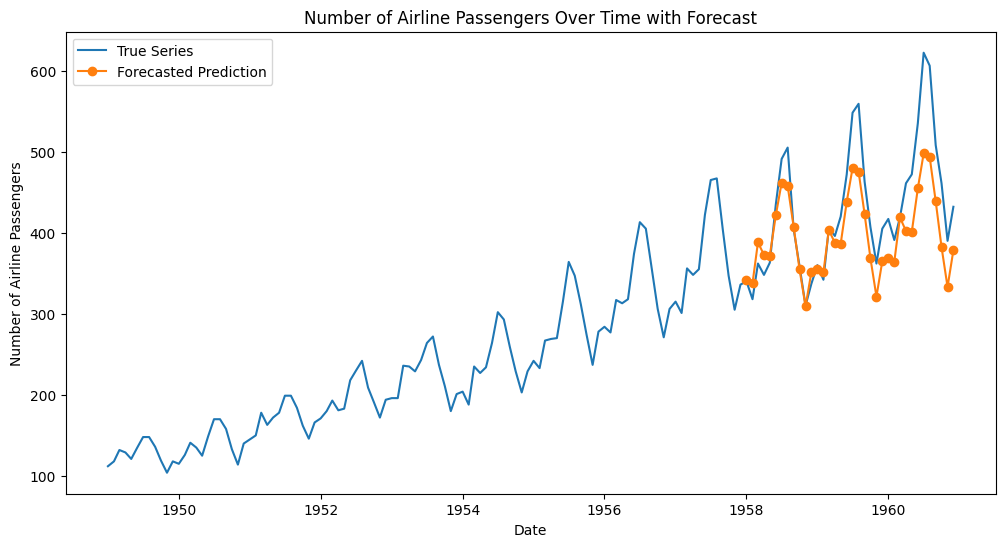

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y.index.to_timestamp(), y.values, label='True Series')
plt.plot(y_test.index.to_timestamp(), y_pred.values, label='Forecasted Prediction', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Airline Passengers')
plt.title('Number of Airline Passengers Over Time with Forecast')
plt.legend()
plt.show()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import models

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [5]:
series = y.values.astype(np.float32)

# Standardize the series
scaler = StandardScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# Prepare data
X_std, Y_std = [], []
for i in range(len(series_scaled) - seq_length):
    X_std.append(series_scaled[i:i+seq_length])
    Y_std.append(series_scaled[i+seq_length])
X_std = np.array(X_std)
Y_std = np.array(Y_std)

# Train/validation split
X_train, X_test, Y_train, Y_test = temporal_train_test_split(X_std, Y_std, test_size=0.2)

X_train_tensor = torch.from_numpy(X_train).unsqueeze(-1).float()
Y_train_tensor = torch.from_numpy(Y_train).reshape(-1, 1).float()
X_test_tensor = torch.from_numpy(X_test).unsqueeze(-1).float()
Y_test_tensor = torch.from_numpy(Y_test).reshape(-1, 1).float()

X_train_tensor.shape, Y_train_tensor.shape

(torch.Size([12, 128, 1]), torch.Size([12, 1]))

In [6]:
model = models.DecompositionTimeSeriesTransformer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, Y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.2811
Epoch 1, Loss: 0.7141
Epoch 2, Loss: 0.6903
Epoch 3, Loss: 0.6986
Epoch 4, Loss: 0.5618
Epoch 5, Loss: 0.4641
Epoch 6, Loss: 0.3326
Epoch 7, Loss: 0.3453
Epoch 8, Loss: 0.3209
Epoch 9, Loss: 0.3179
Epoch 10, Loss: 0.3470
Epoch 11, Loss: 0.3070
Epoch 12, Loss: 0.2554
Epoch 13, Loss: 0.2366
Epoch 14, Loss: 0.2059
Epoch 15, Loss: 0.2280
Epoch 16, Loss: 0.2344
Epoch 17, Loss: 0.2338
Epoch 18, Loss: 0.2073
Epoch 19, Loss: 0.2025
Epoch 20, Loss: 0.2013
Epoch 21, Loss: 0.1802
Epoch 22, Loss: 0.1857
Epoch 23, Loss: 0.2298
Epoch 24, Loss: 0.1657
Epoch 25, Loss: 0.1574
Epoch 26, Loss: 0.1769
Epoch 27, Loss: 0.1881
Epoch 28, Loss: 0.1995
Epoch 29, Loss: 0.1609
Epoch 30, Loss: 0.1459
Epoch 31, Loss: 0.1500
Epoch 32, Loss: 0.1419
Epoch 33, Loss: 0.1787
Epoch 34, Loss: 0.1777
Epoch 35, Loss: 0.1904
Epoch 36, Loss: 0.1250
Epoch 37, Loss: 0.1174
Epoch 38, Loss: 0.1687
Epoch 39, Loss: 0.1453
Epoch 40, Loss: 0.1462
Epoch 41, Loss: 0.1087
Epoch 42, Loss: 0.0988
Epoch 43, Loss: 0.104

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper function for LSTM/Transformer models
def eval_model(model, X_test_tensor, Y_test_tensor, scaler=None):
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).squeeze().cpu().numpy()
        targets = Y_test_tensor.squeeze().cpu().numpy()
        if scaler is not None:
            preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
            targets = scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
        mse = mean_squared_error(targets, preds)
        mae = mean_absolute_error(targets, preds)
    return mse, mae

# LSTMForecast (standardized)
mse, mae = eval_model(model, X_test_tensor, Y_test_tensor, scaler)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 1242.2231, MAE: 32.2612


In [8]:
# Recursive forecast on scaled data
def recursive_forecast(model, context, forecast_steps):
    preds = []
    model.eval()
    with torch.no_grad():
        for _ in range(forecast_steps):
            input_seq = torch.from_numpy(context).unsqueeze(0).unsqueeze(-1)
            pred = model(input_seq).item()
            preds.append(pred)
            context = np.roll(context, -1)
            context[-1] = pred
    return preds

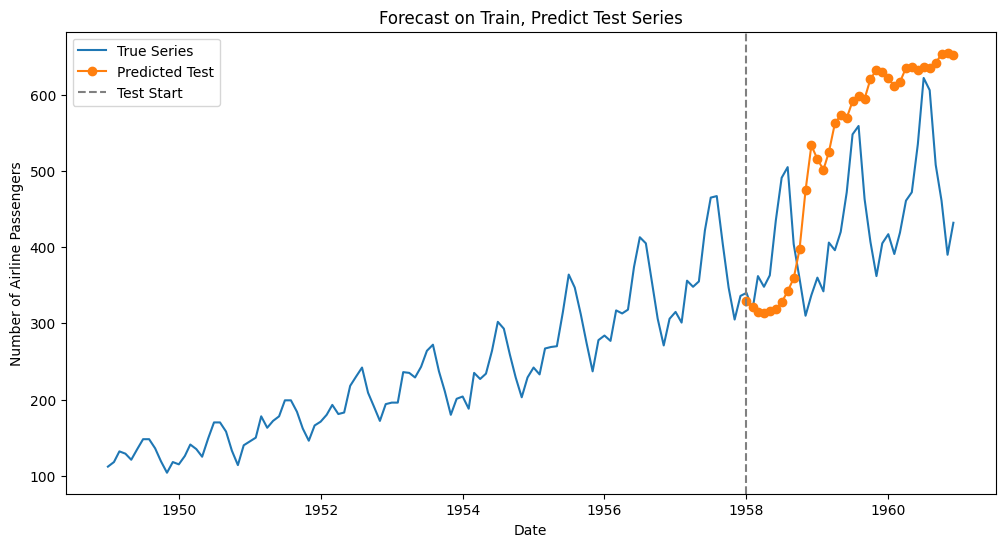

In [9]:
# Forecast on train part to generate the test part of the series
context = series_scaled[:len(y_train)]
forecast_steps = len(y_test)
preds_test_std = recursive_forecast(model, context, forecast_steps=forecast_steps)

# Prepare indices for plotting
pred_index = y_test.index
true_test = y_test.values
pred_test = scaler.inverse_transform(np.array(preds_test_std).reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(y.index.to_timestamp(), y.values, label='True Series')
plt.plot(pred_index.to_timestamp(), pred_test, label='Predicted Test', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Airline Passengers')
plt.title('Forecast on Train, Predict Test Series')
plt.axvline(x=pred_index[0].to_timestamp(), color='gray', linestyle='--', label='Test Start')
plt.legend()
plt.show()